All the imports needed for the running of the script, Updated as the experemnt goes 

In [61]:
import pandas as pd 
import numpy as np 
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from datetime import datetime, timedelta
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
warnings.filterwarnings('ignore')
import progressbar
import tensorflow as ts
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from random import random
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LG
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Data preprocessing. This converts a timestamp in the format %M:%S%S.%f%f Where 
- %M is Minutes with no padded zeros 
- %S is Seconds with zeros padded to the left
- %f is Milliseconds with no padded zeros 

To milliseconds. 

In [2]:
def memory_gbts(unit) : 
    local_unit = 0.0
    if unit.endswith("K"):
        local_unit = float(unit[:-1])/1e9
    elif unit.endswith("M"): 
        local_unit = float(unit[:-1])/1e6
    elif unit.endswith("G") : 
        local_unit = float(unit[:-1])/1e3
    else : 
        local_unit = float(unit)/1e12
    return local_unit

In [3]:
def memory_converter(memory) :
    memory_over_terabyte = []
    for unit in memory :
        local_unit = memory_gbts(unit)
            #print(unit)
        memory_over_terabyte.append(local_unit)
    return memory_over_terabyte

In [4]:
def time_converter(timestamp):
    broken_time = timestamp.split(".")
    milliseconds = float("0." + broken_time[-1]) * 1000
    borken_farther = broken_time[0].split(":")
    seconds = int(borken_farther[-1])
    minutes = int(borken_farther[0])
    total_seconds = seconds + minutes*60
    total_milliseconds = milliseconds + total_seconds*1000
    return total_milliseconds

This function extracts the time at which the file was logged from the file name and returns it as a timestamp 

In [5]:
def get_timestamp(filename) : 
    timestamp = filename[8:-4].replace('_',':')
    return timestamp

The following cell defines the column names for the read text files for when they are converted to a data frame

In [6]:
column_names = ["Process ID","User","PR","NI","VIRT","RES","SHR","S","[%CPU]","[%MEM]","TIME+","Args","Timestamp","Benign"]

This function will go through all files in any given directory and count how many are there. This is only used for updating the progressbar and is not nessesary for understanding the training process

In [7]:
def get_files_count(root,counter = 0):
    counter += 1
    for root, dirs, files in os.walk(root, topdown=True):
        for name in files:
            if name.endswith(".txt") : 
                counter += 1
        for name in dirs:
            new_path = os.path.join(root, name)
            counter = get_files_count(new_path,counter)
    return counter 

In [8]:
file_count = get_files_count(".")
counter = 0
bar = progressbar.ProgressBar(maxval=100, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [9]:
def progressbar_ignite():
    global counter,bar
    counter = 0
    bar.start()

In [10]:
def progressbar_stop():
    global bar
    bar.update(100)
    bar.finish()

In [11]:
def update_progressbar(counter) : 
    global file_count,bar
    percent_done = counter/float(file_count)
    percent = int(percent_done*100)
    bar.update(percent)

Few cells for nicely presented output

In [12]:
def nice_graph_init(ylabel = "process count", xlabel = "Probability", title = r"Likelyhood of a process being benign",figsize = (8,6)): 
    plt.style.use('dark_background')
    figure = plt.figure(figsize = figsize)
    figure.subplots_adjust(bottom = 0.22)
    ax = figure.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title, fontsize = 16, fontfamily = "monospace")
    ax.set_ylabel(ylabel, fontsize = 14, fontfamily = "monospace")
    ax.set_xlabel(xlabel, fontsize = 14, fontfamily = "monospace")
    ax.minorticks_on()
    return ax,figure

In [13]:
def nice_graph_finish(figure,ax,filename = "plot.png"):
    ax.xaxis.set_tick_params(length = 5, width = 1)
    ax.yaxis.set_tick_params(length = 5, width = 1)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

This cell makes sure the data is in the correct format

In [14]:
def turn_to_X(df) : 
    X = df.values
    X = np.asarray(X).astype('float32')
    return X

In [15]:
def list_to_array(data):
    df = pd.DataFrame(data,columns = column_names)
    X = df.drop(["Process ID","User","PR","NI","S","Args","Timestamp","Benign"],axis =1,inplace=False)
    X = turn_to_X(X)
    Y = df["Benign"].values
    Y = np.reshape(Y, (len(Y),1))
    return X,Y

In [16]:
def y_edit(y,N,tracker):
    prev_i = 0
    itters = 0
    ys = np.zeros((y.shape[0] - N*len(tracker),1))
    for num in tracker :
        ys[prev_i - N*itters : num - N*(itters+1)] = y[prev_i : num - N]
        itters += 1
        prev_i = num
    return ys

In [17]:
def rows_to_cells(rows, N,tracker) : 
    rows = np.array(rows)
    cells = np.zeros((rows.shape[0] - N*len(tracker),N,6))
    prev_i = 0
    itter = 0
    for num in tracker :
        for i in range(prev_i,num - N) :
            cells[i - N*itter,:,:] = rows[i:i+N,:]
        prev_i = num
        itter += 1
    return cells

In [18]:
def concatinate(full,new) : 
    return np.concatenate((full,new), axis = 0)

In [19]:
def get_summary_output(filename) : 
    # Reads a text file with columns seperated by tabs and stores it in a data frame object
    filein = open(filename, "r")
    # Stores the data contained in the data frame object in an array 
    lines = filein.readlines()
    lines = lines[1:6]
    """
    This is how these lines look like 
    ['Mem:', '7.3G', 'total,', '6.5G', 'used,', '780M', 'free,', '190M', 'buffers']
    ['Swap:', '2.0G', 'total,', '8.7M', 'used,', '2.0G', 'free,', '3.7G', 'cached']
    ['800%cpu', '62%user', '0%nice', '69%sys', '669%idle', '0%iow', '0%irq', '0%sirq', '0%host']
    """
    metrics = {}
    metric_list = []
    
    metric_list.append(memory_gbts((" ".join(lines[0].split())).split(" ")[3]))
    metrics["UsedMem"] = metric_list[-1]
    metric_list.append(memory_gbts((" ".join(lines[1].split())).split(" ")[3]))
    metrics["UsedSwp"] =  metric_list[-1]
    cpu_tokens = " ".join(lines[2].split()).split(" ")
    metric_list.append(float(cpu_tokens[1].split("%")[0]))
    metrics["CPUuser"] = metric_list[-1]
    metric_list.append(float(cpu_tokens[3].split("%")[0]))
    metrics["CPUsyst"] = metric_list[-1]
    
    return metric_list

In [31]:
def get_summary_input(df) : 
    
    kernal_calls = df["Args"].values
    users = np.unique(df["User"].values)
    process_ID = np.max(df["Process ID"].values)
    time = df["TIME+"].values
    all_items = []
    APIs = {}
    statistics = np.zeros((1,15))
    for item in kernal_calls : 
        tokens = item.split(" ")
        for token in tokens : 
            if(token.startswith("[")) : 
                token = token[1:]
            if(token.endswith("]")) : 
                token = token[:-1]
            if len(token) > 4 : 
                token = token[:4]
            all_items.append(token)
    distinct = np.unique(all_items)
    api_counter = np.zeros_like(distinct, dtype = float)
    for key in distinct : 
        APIs[key] = 0
    for item in kernal_calls : 
        tokens = item.split(" ")
        for token in tokens : 
            if(token.startswith("[")) : 
                token = token[1:]
            if(token.endswith("]")) : 
                token = token[:-1]
            if len(token) > 4 : 
                token = token[:4]
            APIs[token] += 1
    i = 0
    for key in distinct : 
        api_counter[i] = APIs[key]
        i += 1
    statistics[0,0] = np.sum(api_counter)
    statistics[0,1] = users.shape[0]
    statistics[0,2] = api_counter.mean()
    statistics[0,3] = np.median(api_counter)
    statistics[0,4] = api_counter.std()
    top_vals = api_counter.argsort()[-4:][::-1]
    statistics[0,5] = top_vals[0]
    statistics[0,6] = top_vals[1]
    statistics[0,7] = top_vals[2]
    statistics[0,8] = top_vals[3]
    statistics[0,10] = process_ID
    statistics[0,9] = len(distinct)
    statistics[0,11] = np.max(time)
    statistics[0,12] = np.mean(time)
    statistics[0,13] = np.median(time)
    statistics[0,14] = np.std(time)
    return statistics

In [20]:
def reader(filename,safe_filename,all_data, benign = 1) : 
    # Reads a text file with columns seperated by tabs and stores it in a data frame object
    df = pd.read_csv(filename, delimiter = "\t", skiprows = [0,1,2,3,4,5,-1])
    # Stores the data contained in the data frame object in an array 
    data = df.iloc[:,0].values
    i = 0
    # Loop through all the data points 
    for d in data[:-1] :
        try :
            row = []
            # The variable d at this point is a whole line, with some awckward spacing between the different 
            # variables, so here all spaces are removed by the split method, then are rejoined with a single 
            # space beteween them by the use of the join method
            d = " ".join(d.split())
            # Storing all the data up to the 12th element in row, the 12th and beyond element needs further processing 
            row = d.split(" ")[:11]
            # Storing all the elements including and beyond the 12th element. They are saved all as a single variable
            # this variable is the API caller.
            APIs = d.split(" ")[11:]
            row.append(" ".join(APIs))
            # converting the PID (process ID) column to Integer
            row[0] = int(row[0])
            # Convert the memory information to numarical values 
            row[4:7] = memory_converter(row[4:7])
            row[9] = float(row[9])
            row[8] = float(row[8])
            # Convert timestamps into millisecond values 
            row[10] = time_converter(row[10])
            # Collect the sampling time from the filename 
            row.append(get_timestamp(safe_filename))
            # Indicate whether this row corrospond to a benign or a melign run 
            row.append(benign)
            # The row is done being processed and is stored
            if(np.sum(row[4:7]) > 0 ) : 
                all_data.append(row)
            i += 1
        # For lines which might contain contaminated or corrupt data or data in different format
        except ValueError : 
            #print(safe_filename, " In the line " , i)
            #print(d)
            continue
    return all_data

In [21]:
def list_to_df(data):
    df = pd.DataFrame(data,columns = column_names)
    X = df.drop(["Benign"],axis =1,inplace=False)
    return X

Okay so this function will produce summary statistics about the top file being processed. This description will
keep being updated as we go, Currently the summary stats we include are : 
- number of different kernal API calls 
- number of calling users 
- number of calls performed by the most calling API 
- number of calls performed by the second most calling API
- number of calls performed by the third mot calling API 
- number of calls performed by the fourth most calling API
- the ammount of memory and cpu occupied by each of those 
- the total number of calls 
- number of calls that doesn't have any cpu or memory usage to it
- the average time since the start of each of those processes 
- The mean API count 
- The std of the API calls

In [28]:
N_features = 15


In [22]:
def process_file(filename,safe_filename,all_data, benign = 1) :
    all_data = reader(filename, safe_filename , all_data , benign)
    x = get_summary_input(list_to_df(all_data))
    y = get_summary_output(filename)
    return x,y


In [23]:
def evil_processing(root,benign):
    global counter
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        # Looping through all the child files 
        for name in files:
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                try :
                    if(random() > 0.0) : 
                        file_path = os.path.join(root, name)
                        # Reading the file's contents and storing it in the list
                        x,y = process_file(file_path,name,[],benign=benign)
                        evil_inset(x,y)
                        # We read one more file :) . (for the progressbar) 
                    counter += 1
                except ValueError : 
                    print("The current dimensions of Y global is : " , global_Y.shape)
                    print("The current dimensions of Y locaal is : " , loc_y.shape)
        # For each of the child directories we will check         
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                continue
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :     
                evil_processing(new_path,0) 
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                evil_processing(new_path,benign)

In [24]:
def good_processing(root,benign):
    global counter
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        # Looping through all the child files 
        for name in files:
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                try :
                    if(random() > 0.0) : 
                        file_path = os.path.join(root, name)
                        # Reading the file's contents and storing it in the list
                        x,y = process_file(file_path,name,[],benign=benign)
                        inset(x,y)
                        # We read one more file :) . (for the progressbar) 
                    counter += 1
                except ValueError : 
                    print("The current dimensions of Y global is : " , global_Y.shape)
                    print("The current dimensions of Y locaal is : " , loc_y.shape)
        # For each of the child directories we will check         
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                good_processing(new_path,1)
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :     
                continue 
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                good_processing(new_path,benign)

In [25]:
def inset(x,y) : 
    global Good_X,Good_Y,filled
    Good_X[filled, : ] = x
    Good_Y[filled, : ] = y
    filled += 1

In [26]:
def evil_inset(x,y) : 
    global Evil_X,Evil_Y,Evil_filled
    Evil_X[Evil_filled, : ] = x
    Evil_Y[Evil_filled, : ] = y
    Evil_filled += 1

In [33]:
def score_metric(metric,y,ypred) : 
    if metric == "MSE" : 
        return np.sum((y-ypred)**2, axis = 1)/y.shape[0]
    if metric == "MAE" : 
        return np.sum(np.abs(y-ypred), axis = 1)/y.shape[0]

In [37]:
def display_performance(scores) : 
    for key in scores.keys() : 
        print("The Algorithim ", key, " Performed with ", scores[key]*100, " Accuracy")

In [38]:
def lg_only(x_train,x_test,y_train,y_test) : 
    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)
    x_test = ss.transform(x_test)
    lg = LG()
    lg.fit(x_train,y_train)
    y_pred = lg.predict_proba(x_test)
    return y_pred

In [39]:
def svm_only(x_train,x_test,y_train,y_test) : 
    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)
    x_test = ss.transform(x_test)
    svm = SVC()
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    return y_pred

In [40]:
def running_classical_ML(x_train,x_test,y_train,y_test) : 
    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)
    x_test = ss.transform(x_test)
    scores = {}
    score = 0
    for i in range(10,15) : 
        knn = KNN(n_neighbors = i)
        knn.fit(x_train,y_train)
        y_pred = knn.predict(x_test)
        if accuracy_score(y_pred,y_test) > score : 
            score = accuracy_score(y_pred,y_test)
    scores["KNN"] = score 
    score = 0
    svm = SVC()
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    print(confusion_matrix(y_pred,y_test))
    scores["SVM"] = accuracy_score(y_pred,y_test) 
    nb = GNB()
    nb.fit(x_train,y_train)
    y_pred = nb.predict(x_test)
    print(confusion_matrix(y_pred,y_test))
    scores["GNB"] = accuracy_score(y_pred,y_test) 
    dtc = DTC()
    dtc.fit(x_train,y_train)
    y_pred = dtc.predict(x_test)
    print(confusion_matrix(y_pred,y_test))
    scores["DTC"] = accuracy_score(y_pred,y_test) 
    rfc = RFC()
    rfc.fit(x_train,y_train)
    y_pred = rfc.predict(x_test)
    print(confusion_matrix(y_pred,y_test))
    scores["RFC"] = accuracy_score(y_pred,y_test) 
    display_performance(scores)

In [41]:
def time_extractor(filename) : 
    timestamp = filename[8:-4].replace('_',':')
    dt = datetime.strptime(timestamp, "%H:%M:%S")
    a_timedelta = dt - datetime(2000, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds

In [48]:
def read_3_files_0(current_file,previous_file,holder,curr_data):
    global N_files,N_features
    s1 = time_extractor(current_file)
    if previous_file == "" :
        holder = np.zeros((N_files,N_features+4))
        holder[0, : ] = curr_data
        return holder,False
    s2 = time_extractor(previous_file)
    if s1 - s2 == 1 : 
        if np.sum(holder[-1,:]) != 0 : 
            holder[0:-1, :] = holder[1:,:]
            holder[-1,:] = curr_data
            return holder, True
        else :
            for i in range(N_files): 
                if np.sum(holder[i,:]) == 0 :
                    holder[i,:] = curr_data
                    return holder,False
    else : 
        holder = np.zeros((N_files,N_features+4))
        holder[0, : ] = curr_data
        return holder,False  

In [49]:
def read_3_files_1(current_file,previous_file,holder,curr_data):
    global N_files,N_features
    s1 = time_extractor(current_file)
    if previous_file == "" :
        holder = np.zeros((N_features+4,N_files))
        holder[:, 0 ] = curr_data.reshape(-1)
        return holder,False
    s2 = time_extractor(previous_file)
    if s1 - s2 == 1 : 
        if np.sum(holder[:,-1]) != 0 : 
            holder[:,0:-1] = holder[:,1:]
            holder[:,-1] = curr_data.reshape(-1)
            return holder,True
        else :
            for i in range(N_files): 
                if np.sum(holder[:,i]) == 0 :
                    holder[:,i] = curr_data.reshape(-1)
                    return holder,False
    else : 
        holder = np.zeros((N_features+4,N_files))
        holder[:,0] = curr_data.reshape(-1)
        return holder,False

In [50]:
def multi_evil_inset(record) : 
    global multi_Evil_X,multi_Evil_filled
    multi_Evil_X[multi_Evil_filled, : ,:] = record
    multi_Evil_filled += 1

In [51]:
def multi_good_inset(record) : 
    global multi_Good_X,multi_Good_filled
    multi_Good_X[multi_Good_filled, : ,:] = record
    multi_Good_filled += 1

In [68]:
def multi_evil_processing(root,benign,orientation = 0):
    global counter,holder,N_files
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        # Looping through all the child files 
        previous_name = ""
        files.sort()
        #print(files)
        for name in files:
            #print(len(name))
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                try :
                    if(random() > 0.0) : 
                        file_path = os.path.join(root, name)
                        # Reading the file's contents and storing it in the list
                        x,y = process_file(file_path,name,[],benign=benign)
                        y = np.reshape(y,(1,-1))
                        record = np.hstack((x,y))
                        if orientation == 0 : 
                            holder,flag = read_3_files_0(name,previous_name, holder, record)
                        else : 
                            holder,flag = read_3_files_1(name,previous_name, holder, record)
                        previous_name = name
                        if flag :
                            multi_evil_inset(holder)
                        # We read one more file :) . (for the progressbar) 
                    counter += 1
                except FileNotFound: 
                    print("The current dimensions of holder is : " , holder)
                    #print("The current dimensions of Y locaal is : " , loc_y.shape)
        # For each of the child directories we will check  
            
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                continue
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :     
                multi_evil_processing(new_path,0) 
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                multi_evil_processing(new_path,benign)

In [69]:
def multi_good_processing(root,benign,orientation = 0):
    global counter,holder,N_files
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        #print(files)
        # Looping through all the child files 
        previous_name = ""
        files.sort()
        #print(files)
        for name in files:
            #print(len(name))
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                try :
                    if(random() > 0.0) : 
                        file_path = os.path.join(root, name)
                        # Reading the file's contents and storing it in the list
                        x,y = process_file(file_path,name,[],benign=benign)
                        y = np.reshape(y,(1,-1))
                        record = np.hstack((x,y))
                        if orientation == 0 :
                            holder,flag = read_3_files_0(name,previous_name, holder, record)
                        else :
                            holder,flag = read_3_files_1(name,previous_name, holder, record)
                        if flag :
                            multi_good_inset(holder)
                        # We read one more file :) . (for the progressbar) 
                    counter += 1
                except FileNotFound: 
                    print("The current dimensions of holder is : " , holder)
                    #print("The current dimensions of Y locaal is : " , loc_y.shape)
        # For each of the child directories we will check  
            previous_name = name
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                multi_good_processing(new_path,0) 
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :     
                continue 
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                multi_good_processing(new_path,benign)

# Experiment V

### Data processing

In [32]:
filled = 0 
TOTAL = 100000
Good_X = np.zeros((TOTAL,N_features))
Good_Y = np.zeros((TOTAL,4))
progressbar_ignite()
good_processing(".", 1)
progressbar_stop()

[=========================================================================] 100%


In [54]:
Evil_filled = 0 
TOTAL_EVIL = 1000000
Evil_X = np.zeros((TOTAL_EVIL,N_features))
Evil_Y = np.zeros((TOTAL_EVIL,4))
progressbar_ignite()
evil_processing(".", 1)
progressbar_stop()

In [55]:
Good_X = Good_X[:filled,:]
Good_Y = Good_Y[:filled, :]
Evil_X = Evil_X[:Evil_filled,:]
Evil_Y = Evil_Y[:Evil_filled, :]

In [59]:
ss_x = StandardScaler()
ss_y = StandardScaler()
Good_X = ss_x.fit_transform(Good_X)
Evil_X = ss_x.transform(Evil_X)
Good_Y = ss_y.fit_transform(Good_Y)
Evil_Y = ss_y.transform(Evil_Y)

### Model

In [62]:
good_regressor = LinearRegression()
good_regressor.fit(Good_X,Good_Y)
evil_regressor = LinearRegression()
evil_regressor.fit(Evil_X,Evil_Y)

LinearRegression()

### Evaluation on test set 

In [63]:
y_good_good = good_regressor.predict(Good_X[:,:])
y_evil_good = good_regressor.predict(Evil_X[:,:])
y_good_evil = evil_regressor.predict(Good_X[:,:])
y_evil_evil = evil_regressor.predict(Evil_X[:,:])

In [64]:
good_scores_good = score_metric("MAE",Good_Y, y_good_good)
evil_scores_good = score_metric("MAE",Evil_Y, y_evil_good)
good_scores_evil = score_metric("MAE",Good_Y, y_good_evil)
evil_scores_evil = score_metric("MAE",Evil_Y, y_evil_evil)

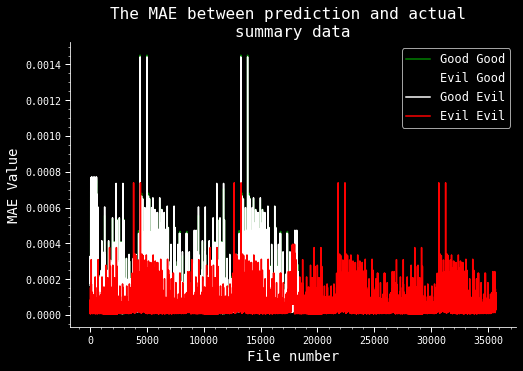

In [65]:
import matplotlib as mpl  
mpl.rc('font',family='monospace')
ax, fig = nice_graph_init(title = "The MAE between prediction and actual \nsummary data", xlabel = "File number", ylabel = "MAE Value")
plt.plot(good_scores_good, color = "green", label = "Good Good")
plt.plot(evil_scores_good, color = "black", label = "Evil Good")
plt.plot(good_scores_evil, color = "white", label = "Good Evil")
plt.plot(evil_scores_evil, color = "red", label = "Evil Evil")
plt.legend(prop={"size":12})
nice_graph_finish(fig,ax,filename = "lgFinal.png")

# Experiment VI

### Data processing

In [70]:
N_files = 5
orientation = 0
rows = N_files
cols = N_features+4
if orientation != 0 : 
    rows = cols
    cols = N_files
holder = np.zeros((rows,cols))
TOTAL = 100000
multi_Evil_filled = 0
multi_Evil_X = np.zeros((TOTAL,rows,cols))
multi_Good_filled = 0
multi_Good_X = np.zeros((TOTAL,rows,cols))
progressbar_ignite()
multi_evil_processing(".", 1, orientation = orientation)
progressbar_stop()
holder = np.zeros((rows,cols))
progressbar_ignite()
multi_good_processing(".", 1, orientation = orientation)
progressbar_stop()

In [71]:
multi_Evil_X = multi_Evil_X[:multi_Evil_filled, : ,:]
multi_Good_X = multi_Good_X[:multi_Good_filled, : ,:]
good_n_evil = np.vstack((multi_Good_X,multi_Evil_X))
good_labels = np.full_like(multi_Good_X[:,0,0],1).reshape(-1,1)
evil_labels = np.full_like(multi_Evil_X[:,0,0],0).reshape(-1,1)
scores = concatinate(good_labels,evil_labels)
x_train,x_test,y_train,y_test = train_test_split(good_n_evil,scores,test_size = 0.2)

In [72]:
evil_flattened = multi_Evil_X.reshape(multi_Evil_filled*N_files,N_features+4)
good_flattened = multi_Good_X.reshape(multi_Good_filled*N_files,N_features+4)
g00d_labels = np.full_like(good_flattened[:,0],1).reshape(-1,1)
evi1_labe1a = np.full_like(evil_flattened[:,0],0).reshape(-1,1)
flat_all = np.vstack((good_flattened,evil_flattened))
flat_scores = concatinate(g00d_labels,evi1_labe1a)

In [73]:
inputs = min(multi_Evil_filled*N_files,multi_Good_filled*N_files)
x_train = flat_all[:inputs, : ]
x_test = flat_all[inputs:, : ]
y_train = flat_scores[:inputs, : ]
y_test = flat_scores[inputs:, : ]

### Model

In [ ]:
RNN = models.Sequential([
                         layers.Conv1D(12, (N_files) , input_shape=(N_features+4,N_files) ),
                         layers.LSTM(20, activation = "relu", return_sequences=True),
                         layers.Dense(30,activation = "relu"),
                         layers.Conv1D(24,(5), activation = "relu"),
                         layers.LSTM(20, activation = "relu",return_sequences=True),
                         layers.Dense(32,activation = "relu"),
                         layers.Dense(24,activation = "relu"),
                         layers.LSTM(20, activation = "relu",return_sequences=True),
                         layers.Dense(12,activation = "relu"),
                         layers.LSTM(20, activation = "relu"),
                         layers.Dense(1,activation="sigmoid")
                        ])
RNN.compile(optimizer="adam",
              loss = "BinaryCrossentropy",
              metrics=['accuracy'])
RNN.fit(good_n_evil,scores, batch_size=batch_size, epochs=epoches, verbose=verbos,
    validation_data=(x_test,y_test), shuffle=True,
    validation_freq=1,
    max_queue_size=10, workers=3, use_multiprocessing=True)

In [74]:
running_classical_ML(x_train,x_test,y_train,y_test)

ValueError: The number of classes has to be greater than one; got 1 class